In [1]:
import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

class Config:
    # Data settings
    IMAGE_SIZE = 128
    BATCH_SIZE = 32
    DATA_ROOT = "/home/017428515/project_data"
    CONTENT_DIR = "/home/017428515/celeba"
    STYLE_DIR = "/home/017428515/project_data/style_images"
    
    # Training settings
    NUM_EPOCHS = 50
    G_LEARNING_RATE = 2e-4
    D_LEARNING_RATE = 1e-4
    BETA1 = 0.5
    BETA2 = 0.999
    LATENT_DIM = 100
    STYLE_DIM = 512
    TIME_DIM = 256
    NUM_TIMESTEPS = 1000
    
    # Additional settings
    DISC_UPDATES = 2
    LABEL_SMOOTHING = 0.1
    
    # Paths
    CHECKPOINT_DIR = "last_checkpoints"
    SAMPLES_DIR = "last_samples"
    
    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create directories
os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)
os.makedirs(Config.SAMPLES_DIR, exist_ok=True)

print(f"Using device: {Config.DEVICE}")

Using device: cpu


/opt/ohpc/pub/apps/python3/3.11.5/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
class ContentDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_files = [f for f in self.root_dir.glob('*.jpg')]
        print(f"Found {len(self.image_files)} content images")
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        return image

class StyleDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_files = []
        for style_dir in self.root_dir.iterdir():
            if style_dir.is_dir():
                self.image_files.extend(list(style_dir.glob('*.jpg')))
                self.image_files.extend(list(style_dir.glob('*.png')))
        print(f"Found {len(self.image_files)} style images")
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        return image

def get_transform():
    return transforms.Compose([
        transforms.Resize(Config.IMAGE_SIZE),
        transforms.CenterCrop(Config.IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

def setup_datasets():
    transform = get_transform()
    
    content_dataset = ContentDataset(
        root_dir=Config.CONTENT_DIR,
        transform=transform
    )
    
    style_dataset = StyleDataset(
        root_dir=Config.STYLE_DIR,
        transform=transform
    )
    
    content_loader = DataLoader(
        content_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True
    )
    
    style_loader = DataLoader(
        style_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True
    )
    
    return content_loader, style_loader

Found 30000 content images
Found 32097 style images


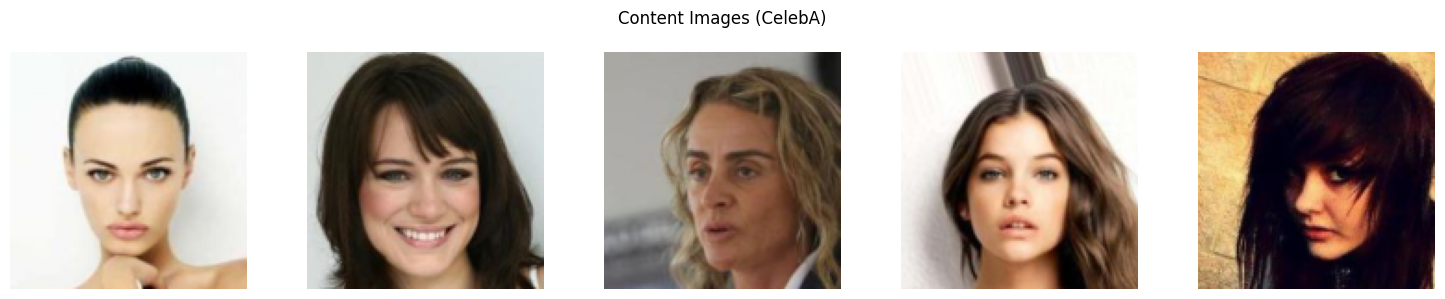

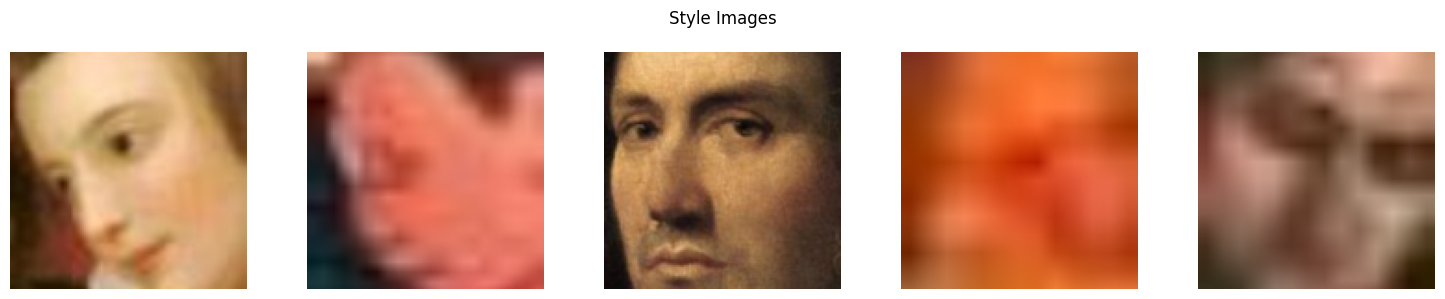


Dataset Statistics:
Content batches: 938
Style batches: 1004
Images per batch: 32
Total content images: 30000
Total style images: 32097


In [4]:
def show_batch_images(dataloader, title, num_images=5):
    # Get a batch of images
    batch = next(iter(dataloader))
    
    # Create a figure
    plt.figure(figsize=(15, 3))
    plt.suptitle(title)
    
    # Show images
    for idx in range(min(num_images, len(batch))):
        plt.subplot(1, num_images, idx + 1)
        img = batch[idx]
        # Denormalize the image
        img = img.cpu() * 0.5 + 0.5
        img = img.permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Create dataloaders
content_loader, style_loader = setup_datasets()

# Show sample images
show_batch_images(content_loader, "Content Images (CelebA)")
show_batch_images(style_loader, "Style Images")

# Print dataset statistics
print(f"\nDataset Statistics:")
print(f"Content batches: {len(content_loader)}")
print(f"Style batches: {len(style_loader)}")
print(f"Images per batch: {Config.BATCH_SIZE}")
print(f"Total content images: {len(content_loader.dataset)}")
print(f"Total style images: {len(style_loader.dataset)}")

In [3]:
class DiffusionScheduler(nn.Module):
    def __init__(self, num_timesteps=Config.NUM_TIMESTEPS):
        super().__init__()
        self.num_timesteps = num_timesteps
        self.register_buffer('beta', torch.linspace(1e-4, 0.02, num_timesteps))
        self.register_buffer('alpha', 1 - self.beta)
        self.register_buffer('alpha_bar', torch.cumprod(self.alpha, dim=0))
        
    def forward(self, x, t):
        t = t.to(self.alpha_bar.device)
        alpha_t = self.alpha_bar[t].view(-1, 1, 1, 1)
        noise = torch.randn_like(x)
        return torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * noise, noise

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # Time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, Config.TIME_DIM),
            nn.SiLU(),
            nn.Linear(Config.TIME_DIM, Config.TIME_DIM)
        )
        
        # Style encoder
        self.style_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, Config.STYLE_DIM)
        )
        
        # Initial projection
        self.initial = nn.Linear(
            Config.LATENT_DIM + Config.STYLE_DIM + Config.TIME_DIM,
            512 * 8 * 8  # Increased initial size for 128x128 output
        )
        
        # Upsampling blocks
        self.up_blocks = nn.ModuleList([
            self._make_up_block(512, 256),
            self._make_up_block(256, 128),
            self._make_up_block(128, 64),
            self._make_up_block(64, 32)
        ])
        
        self.final = nn.Sequential(
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Tanh()
        )
        
    def _make_up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, z, style_img, t):
        batch_size = z.size(0)
        
        # Time embedding
        t_emb = self.time_mlp(t.float().view(batch_size, 1))
        
        # Style embedding
        if style_img.size(0) != batch_size:
            style_img = style_img.expand(batch_size, -1, -1, -1)
        style_feat = self.style_encoder(style_img)
        
        # Combine and project
        x = torch.cat([z, style_feat, t_emb], dim=1)
        x = self.initial(x).view(batch_size, 512, 8, 8)  # Changed to 8x8
        
        # Upsampling
        for block in self.up_blocks:
            x = block(x)
            
        return self.final(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def discriminator_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, 4, 2, 1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(3, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            *discriminator_block(512, 1024),
            nn.Conv2d(1024, 1, 4, 1, 0)
        )
        
    def forward(self, img):
        validity = self.model(img)
        return validity.view(validity.size(0), -1).squeeze(1)

In [ ]:


class Trainer:
    def __init__(self):
        self.device = Config.DEVICE
        self.content_loader, self.style_loader = setup_datasets()
        
        # Initialize models
        self.generator = Generator().to(self.device)
        self.discriminator = Discriminator().to(self.device)
        self.diffusion = DiffusionScheduler().to(self.device)
        
        # Initialize optimizers
        self.g_optimizer = optim.Adam(
            self.generator.parameters(),
            lr=Config.G_LEARNING_RATE,
            betas=(Config.BETA1, Config.BETA2)
        )
        self.d_optimizer = optim.Adam(
            self.discriminator.parameters(),
            lr=Config.D_LEARNING_RATE,
            betas=(Config.BETA1, Config.BETA2)
        )
        
        # Fixed noise for sampling
        self.fixed_noise = torch.randn(16, Config.LATENT_DIM).to(self.device)
        
        # Training history
        self.g_losses = []
        self.d_losses = []
        self.best_loss = float('inf')
        self.current_epoch = 0
        
    def train_step(self, content_images, style_images):
        batch_size = content_images.size(0)
        
        # Match style images batch size
        if style_images.size(0) != batch_size:
            style_images = style_images[:batch_size]
        
        # Generate noise and timesteps
        z = torch.randn(batch_size, Config.LATENT_DIM, device=self.device)
        t = torch.randint(0, self.diffusion.num_timesteps, (batch_size,), device=self.device)
        
        # Generate fake images
        fake_images = self.generator(z, style_images, t)
        
        # Train discriminator
        d_loss_total = 0
        for _ in range(Config.DISC_UPDATES):
            self.d_optimizer.zero_grad()
            
            # Get discriminator outputs
            real_validity = self.discriminator(content_images)
            fake_validity = self.discriminator(fake_images.detach())
            
            # Create smoothed labels
            real_labels = torch.ones_like(real_validity, device=self.device) * (1 - Config.LABEL_SMOOTHING)
            fake_labels = torch.zeros_like(fake_validity, device=self.device) + Config.LABEL_SMOOTHING
            
            # Calculate discriminator loss
            d_loss = (
                F.binary_cross_entropy_with_logits(real_validity, real_labels) +
                F.binary_cross_entropy_with_logits(fake_validity, fake_labels)
            ) * 0.5
            
            d_loss.backward()
            self.d_optimizer.step()
            d_loss_total += d_loss.item()
        
        # Train generator
        self.g_optimizer.zero_grad()
        fake_validity = self.discriminator(fake_images)
        g_loss = F.binary_cross_entropy_with_logits(
            fake_validity,
            torch.ones_like(fake_validity, device=self.device)
        )
        
        g_loss.backward()
        self.g_optimizer.step()
        return g_loss.item(), d_loss_total / Config.DISC_UPDATES
        
    def train(self):
        style_iterator = iter(self.style_loader)
        try:
            for epoch in range(Config.NUM_EPOCHS):
                self.current_epoch = epoch
                epoch_g_loss = 0
                epoch_d_loss = 0
                
                # Create progress bar
                pbar = tqdm(enumerate(self.content_loader), 
                          total=len(self.content_loader),
                          desc=f'Epoch {epoch+1}/{Config.NUM_EPOCHS}')
                
                for i, content_imgs in pbar:
                    # Get style images
                    try:
                        style_imgs = next(style_iterator)
                    except StopIteration:
                        style_iterator = iter(self.style_loader)
                        style_imgs = next(style_iterator)
                    
                    # Move to device
                    content_imgs = content_imgs.to(self.device)
                    style_imgs = style_imgs.to(self.device)
                    
                    # Training step
                    g_loss, d_loss = self.train_step(content_imgs, style_imgs)
                    epoch_g_loss += g_loss
                    epoch_d_loss += d_loss
                    
                    # Update progress bar
                    pbar.set_postfix({
                        'G_loss': f'{g_loss:.4f}',
                        'D_loss': f'{d_loss:.4f}',
                        'GPU': f'{torch.cuda.memory_allocated()/1e9:.1f}GB'
                    })
                    
                    # Save periodic checkpoints
                    if i % 500 == 0:
                        self.save_checkpoint(f'epoch_{epoch}_batch_{i}')
                
                # End of epoch processing
                avg_loss = (epoch_g_loss + epoch_d_loss) / len(self.content_loader)
                self.g_losses.append(epoch_g_loss / len(self.content_loader))
                self.d_losses.append(epoch_d_loss / len(self.content_loader))
                
                # Save best model
                if avg_loss < self.best_loss:
                    self.best_loss = avg_loss
                    self.save_checkpoint('best')
                    print("\nSaved best model checkpoint")
                
                # Regular checkpoints and visualization
                if (epoch + 1) % 5 == 0:  # Every 5 epochs
                    self.save_samples(epoch)
                    self.save_checkpoint(f'epoch_{epoch}')
                    self.plot_losses()
                    torch.cuda.empty_cache()
                
                # Clean GPU memory every other epoch
                if epoch % 2 == 0:
                    torch.cuda.empty_cache()
                    
        except KeyboardInterrupt:
            print("\nTraining interrupted by user.")
            self.save_checkpoint('interrupted')
            
        except Exception as e:
            print(f"\nUnexpected error: {str(e)}")
            self.save_checkpoint('error')
            raise
            
        finally:
            # Save final state
            self.save_checkpoint('final')
            self.plot_losses()
            print("\nTraining finished. Final checkpoint saved.")
    
    def save_samples(self, epoch):
        """Generate and save sample images"""
        self.generator.eval()
        with torch.no_grad():
            # Get style images for sampling
            style_imgs = next(iter(self.style_loader))[:16].to(self.device)
            t = torch.zeros(16).to(self.device)
            fake_imgs = self.generator(self.fixed_noise, style_imgs, t)
            
            # Create and save grid
            img_grid = torchvision.utils.make_grid(fake_imgs, normalize=True, nrow=4)
            torchvision.utils.save_image(img_grid, f"{Config.SAMPLES_DIR}/epoch_{epoch+1}.png")
        self.generator.train()

    def save_checkpoint(self, checkpoint_name):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': self.current_epoch,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'd_optimizer_state_dict': self.d_optimizer.state_dict(),
            'g_losses': self.g_losses,
            'd_losses': self.d_losses,
            'best_loss': self.best_loss
        }
        
        torch.save(checkpoint, f"{Config.CHECKPOINT_DIR}/checkpoint_{checkpoint_name}.pt")
    
    def load_checkpoint(self, checkpoint_path):
        """Load model checkpoint"""
        try:
            print(f"Loading checkpoint: {checkpoint_path}")
            checkpoint = torch.load(checkpoint_path, map_location=self.device)
            
            # Load model states
            self.generator.load_state_dict(checkpoint['generator_state_dict'])
            self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
            self.g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
            self.d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
            
            # Load training state
            self.g_losses = checkpoint['g_losses']
            self.d_losses = checkpoint['d_losses']
            self.best_loss = checkpoint['best_loss']
            self.current_epoch = checkpoint['epoch']
            
            print(f"Successfully resumed from epoch {self.current_epoch}")
            return True

        except Exception as e:
            print(f"Error loading checkpoint: {str(e)}")
            return False
    
    def plot_losses(self):
        """Plot and save loss curves"""
        plt.figure(figsize=(10,5))
        plt.plot(self.g_losses, label='Generator Loss')
        plt.plot(self.d_losses, label='Discriminator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f"{Config.SAMPLES_DIR}/losses.png")
        plt.close()


In [6]:
# Initialize and start training
trainer = Trainer()
trainer.train()

# To resume training later:
# trainer.load_checkpoint('checkpoints/checkpoint_best.pt')
# trainer.train()

Found 30000 content images
Found 32097 style images


Epoch 1/50: 100%|█| 938/938 [03:52<00:00,  4.03it/s, G_loss=2.4635, D_loss=0.550



Saved best model checkpoint


Epoch 2/50: 100%|█| 938/938 [03:51<00:00,  4.05it/s, G_loss=2.7840, D_loss=0.382
Epoch 3/50: 100%|█| 938/938 [03:51<00:00,  4.05it/s, G_loss=3.6393, D_loss=0.405
Epoch 4/50: 100%|█| 938/938 [03:51<00:00,  4.06it/s, G_loss=2.6667, D_loss=0.369
Epoch 5/50: 100%|█| 938/938 [03:50<00:00,  4.06it/s, G_loss=2.3365, D_loss=0.340
Epoch 6/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=3.2737, D_loss=0.371



Saved best model checkpoint


Epoch 7/50: 100%|█| 938/938 [03:50<00:00,  4.06it/s, G_loss=5.0286, D_loss=0.502



Saved best model checkpoint


Epoch 8/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.7189, D_loss=0.385



Saved best model checkpoint


Epoch 9/50: 100%|█| 938/938 [03:50<00:00,  4.06it/s, G_loss=2.6518, D_loss=0.352



Saved best model checkpoint


Epoch 10/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.5309, D_loss=0.34



Saved best model checkpoint


Epoch 11/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.2040, D_loss=0.36
Epoch 12/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=3.2135, D_loss=0.35



Saved best model checkpoint


Epoch 13/50: 100%|█| 938/938 [03:51<00:00,  4.06it/s, G_loss=2.5307, D_loss=0.33
Epoch 14/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.6210, D_loss=0.34



Saved best model checkpoint


Epoch 15/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.6343, D_loss=0.35



Saved best model checkpoint


Epoch 16/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.3491, D_loss=0.33



Saved best model checkpoint


Epoch 17/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.4926, D_loss=0.34



Saved best model checkpoint


Epoch 18/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.8296, D_loss=0.34
Epoch 19/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.3234, D_loss=0.33



Saved best model checkpoint


Epoch 20/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.4377, D_loss=0.33



Saved best model checkpoint


Epoch 21/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.4890, D_loss=0.35



Saved best model checkpoint


Epoch 22/50: 100%|█| 938/938 [03:50<00:00,  4.06it/s, G_loss=3.3080, D_loss=0.36
Epoch 23/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.5278, D_loss=0.34
Epoch 24/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.4806, D_loss=0.34



Saved best model checkpoint


Epoch 25/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.8848, D_loss=0.34



Saved best model checkpoint


Epoch 26/50: 100%|█| 938/938 [03:50<00:00,  4.08it/s, G_loss=2.4063, D_loss=0.33



Saved best model checkpoint


Epoch 27/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.5855, D_loss=0.33
Epoch 28/50: 100%|█| 938/938 [03:50<00:00,  4.08it/s, G_loss=7.3866, D_loss=0.59
Epoch 29/50: 100%|█| 938/938 [03:50<00:00,  4.08it/s, G_loss=2.4794, D_loss=0.34
Epoch 30/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=3.1815, D_loss=0.35
Epoch 31/50: 100%|█| 938/938 [03:50<00:00,  4.08it/s, G_loss=2.4184, D_loss=0.33
Epoch 32/50: 100%|█| 938/938 [03:50<00:00,  4.08it/s, G_loss=2.4865, D_loss=0.34



Saved best model checkpoint


Epoch 33/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.3904, D_loss=0.33



Saved best model checkpoint


Epoch 34/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=3.9670, D_loss=0.35



Saved best model checkpoint


Epoch 35/50: 100%|█| 938/938 [03:50<00:00,  4.06it/s, G_loss=3.9568, D_loss=0.39



Saved best model checkpoint


Epoch 36/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.9362, D_loss=0.33
Epoch 37/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.7050, D_loss=0.37
Epoch 38/50: 100%|█| 938/938 [03:50<00:00,  4.06it/s, G_loss=2.4891, D_loss=0.33
Epoch 39/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.7920, D_loss=0.34
Epoch 40/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=3.4106, D_loss=0.35
Epoch 41/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.4914, D_loss=0.33
Epoch 42/50: 100%|█| 938/938 [03:50<00:00,  4.06it/s, G_loss=2.0947, D_loss=0.33
Epoch 43/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=5.7829, D_loss=0.44
Epoch 44/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=3.7065, D_loss=0.37
Epoch 45/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.4575, D_loss=0.34
Epoch 46/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.8020, D_loss=0.33
Epoch 47/50: 100%|█| 938/938 [03:50<00:00,  4.08it/s, G_loss=5.6505, D_loss=0.47
Epoch 48/50: 100%|█| 938/938


Saved best model checkpoint


Epoch 49/50: 100%|█| 938/938 [03:50<00:00,  4.07it/s, G_loss=2.3267, D_loss=0.33
Epoch 50/50: 100%|█| 938/938 [03:50<00:00,  4.08it/s, G_loss=2.9526, D_loss=0.33



Saved best model checkpoint

Training finished. Final checkpoint saved.


In [15]:
# To resume training later:
trainer = Trainer()
trainer.load_checkpoint('last_checkpoints/checkpoint_best.pt')
trainer.train()

Found 30000 content images
Found 32097 style images
Loading checkpoint: last_checkpoints/checkpoint_best.pt
Successfully resumed from epoch 49


Epoch 1/50: 100%|█| 938/938 [03:53<00:00,  4.01it/s, G_loss=2.3730, D_loss=0.332



Saved best model checkpoint


Epoch 2/50: 100%|█| 938/938 [03:53<00:00,  4.02it/s, G_loss=2.4202, D_loss=0.334
Epoch 3/50: 100%|█| 938/938 [03:52<00:00,  4.03it/s, G_loss=2.2947, D_loss=0.329
Epoch 4/50: 100%|█| 938/938 [03:52<00:00,  4.03it/s, G_loss=2.4551, D_loss=0.351
Epoch 5/50: 100%|█| 938/938 [03:52<00:00,  4.03it/s, G_loss=3.9675, D_loss=0.360
Epoch 6/50: 100%|█| 938/938 [03:52<00:00,  4.03it/s, G_loss=2.4523, D_loss=0.333



Saved best model checkpoint


Epoch 7/50: 100%|█| 938/938 [03:52<00:00,  4.03it/s, G_loss=2.4072, D_loss=0.332
Epoch 8/50: 100%|█| 938/938 [03:52<00:00,  4.03it/s, G_loss=2.5281, D_loss=0.339
Epoch 9/50: 100%|█| 938/938 [03:52<00:00,  4.03it/s, G_loss=3.2931, D_loss=0.367
Epoch 10/50: 100%|█| 938/938 [03:52<00:00,  4.03it/s, G_loss=4.0101, D_loss=0.41
Epoch 11/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.5090, D_loss=0.33
Epoch 12/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.6289, D_loss=0.33



Saved best model checkpoint


Epoch 13/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.5265, D_loss=0.32
Epoch 14/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.4238, D_loss=0.33



Saved best model checkpoint


Epoch 15/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=4.0703, D_loss=0.39
Epoch 16/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.5505, D_loss=0.34



Saved best model checkpoint


Epoch 17/50: 100%|█| 938/938 [03:52<00:00,  4.03it/s, G_loss=2.8943, D_loss=0.34



Saved best model checkpoint


Epoch 18/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.4530, D_loss=0.34
Epoch 19/50: 100%|█| 938/938 [03:51<00:00,  4.05it/s, G_loss=2.3364, D_loss=0.32
Epoch 20/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=3.3659, D_loss=0.35
Epoch 21/50: 100%|█| 938/938 [03:51<00:00,  4.04it/s, G_loss=2.2780, D_loss=0.33



Saved best model checkpoint


Epoch 22/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.9618, D_loss=0.37
Epoch 23/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.4322, D_loss=0.33
Epoch 24/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=3.0937, D_loss=0.35
Epoch 25/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.2815, D_loss=0.33
Epoch 26/50: 100%|█| 938/938 [03:51<00:00,  4.04it/s, G_loss=2.4667, D_loss=0.33



Saved best model checkpoint


Epoch 27/50: 100%|█| 938/938 [03:52<00:00,  4.03it/s, G_loss=2.1129, D_loss=0.33
Epoch 28/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.2708, D_loss=0.33
Epoch 29/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=4.5823, D_loss=0.37
Epoch 30/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.5063, D_loss=0.34
Epoch 31/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.3847, D_loss=0.33
Epoch 32/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.5052, D_loss=0.32
Epoch 33/50: 100%|█| 938/938 [03:51<00:00,  4.04it/s, G_loss=2.3951, D_loss=0.32
Epoch 34/50: 100%|█| 938/938 [03:51<00:00,  4.05it/s, G_loss=2.4978, D_loss=0.32
Epoch 35/50: 100%|█| 938/938 [03:51<00:00,  4.04it/s, G_loss=2.3791, D_loss=0.33



Saved best model checkpoint


Epoch 36/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.6333, D_loss=0.34



Saved best model checkpoint


Epoch 37/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.5277, D_loss=0.32



Saved best model checkpoint


Epoch 38/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.3160, D_loss=0.34
Epoch 39/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=4.5360, D_loss=0.41
Epoch 40/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=3.5088, D_loss=0.34
Epoch 41/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.8726, D_loss=0.33



Saved best model checkpoint


Epoch 42/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.3908, D_loss=0.33



Saved best model checkpoint


Epoch 43/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.4696, D_loss=0.32
Epoch 44/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.4277, D_loss=0.33



Saved best model checkpoint


Epoch 45/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.3553, D_loss=0.35
Epoch 46/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.5565, D_loss=0.33
Epoch 47/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.3481, D_loss=0.33
Epoch 48/50: 100%|█| 938/938 [03:52<00:00,  4.03it/s, G_loss=2.6096, D_loss=0.33



Saved best model checkpoint


Epoch 49/50: 100%|█| 938/938 [03:52<00:00,  4.03it/s, G_loss=2.3508, D_loss=0.33
Epoch 50/50: 100%|█| 938/938 [03:52<00:00,  4.04it/s, G_loss=2.6072, D_loss=0.33



Training finished. Final checkpoint saved.


In [19]:
class StyleGANInference:
    def __init__(self, checkpoint_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.generator = Generator().to(self.device)
        self.load_checkpoint(checkpoint_path)
        self.transform = get_transform()
        
    def load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.generator.eval()
        
    def load_image(self, image_path):
        image = Image.open(image_path).convert('RGB')
        return self.transform(image).unsqueeze(0).to(self.device)
    
    def generate_from_style(self, content_image_path, style_image_path):
        content_img = self.load_image(content_image_path)
        style_img = self.load_image(style_image_path)
        
        with torch.no_grad():
            z = torch.randn(1, Config.LATENT_DIM, device=self.device)
            t = torch.zeros(1, device=self.device)
            generated = self.generator(z, style_img, t)
            
        return self.tensor_to_image(generated)
    
    @staticmethod
    def tensor_to_image(tensor):
        tensor = (tensor.squeeze(0).cpu() + 1) / 2.0
        return tensor.permute(1, 2, 0).numpy()

In [17]:
class ModelComparison:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.vgg = models.vgg16(pretrained=True).features.to(self.device).eval()
        
    def calculate_metrics(self, generated_image, target_image):
        # Convert to tensors if needed
        if isinstance(generated_image, np.ndarray):
            generated_image = torch.from_numpy(generated_image).permute(2, 0, 1).unsqueeze(0)
        if isinstance(target_image, np.ndarray):
            target_image = torch.from_numpy(target_image).permute(2, 0, 1).unsqueeze(0)
            
        metrics = {
            'PSNR': self.calculate_psnr(generated_image, target_image),
            'SSIM': self.calculate_ssim(generated_image, target_image),
            'FID': self.calculate_fid(generated_image, target_image)
        }
        return metrics
    
    def calculate_psnr(self, img1, img2):
        mse = F.mse_loss(img1, img2)
        return -10 * torch.log10(mse)
    
    def calculate_ssim(self, img1, img2):
        # Simplified SSIM calculation
        C1 = (0.01 * 255)**2
        C2 = (0.03 * 255)**2
        
        mu1 = F.avg_pool2d(img1, kernel_size=11, stride=1, padding=5)
        mu2 = F.avg_pool2d(img2, kernel_size=11, stride=1, padding=5)
        
        sigma1_sq = F.avg_pool2d(img1**2, kernel_size=11, stride=1, padding=5) - mu1**2
        sigma2_sq = F.avg_pool2d(img2**2, kernel_size=11, stride=1, padding=5) - mu2**2
        sigma12 = F.avg_pool2d(img1*img2, kernel_size=11, stride=1, padding=5) - mu1*mu2
        
        ssim = ((2*mu1*mu2 + C1)*(2*sigma12 + C2))/((mu1**2 + mu2**2 + C1)*(sigma1_sq + sigma2_sq + C2))
        return ssim.mean()
    
    def calculate_fid(self, img1, img2):
        # Extract features
        with torch.no_grad():
            feat1 = self.vgg(img1)
            feat2 = self.vgg(img2)
        
        # Calculate statistics
        mu1, sigma1 = feat1.mean(dim=[2,3]), feat1.var(dim=[2,3])
        mu2, sigma2 = feat2.mean(dim=[2,3]), feat2.var(dim=[2,3])
        
        # Calculate FID
        diff = mu1 - mu2
        covmean = torch.sqrt((sigma1 + sigma2) / 2)
        fid = torch.sum(diff**2) + torch.sum(sigma1 + sigma2 - 2*covmean)
        return fid

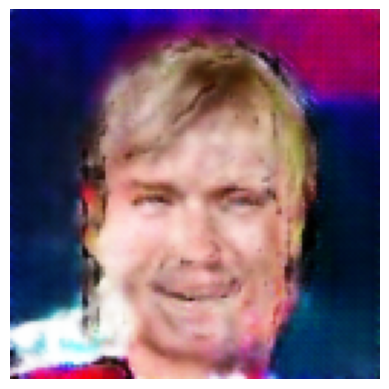

'comparison = ModelComparison()\nmetrics = comparison.calculate_metrics(generated_image, target_image)\nprint("Metrics:", metrics)\n'

In [20]:
# For inference
inference = StyleGANInference("last_checkpoints/checkpoint_best.pt")
result = inference.generate_from_style("celeba/048821.jpg", "project_data/style_images/pop-art/0.1010_jimi-hendrix.jpg!Blog.jpg")
plt.imshow(result)
plt.axis('off')
plt.show()

# For comparison
'''comparison = ModelComparison()
metrics = comparison.calculate_metrics(generated_image, target_image)
print("Metrics:", metrics)
'''


In [15]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
class ModelEvaluator:
    def __init__(self, generator, discriminator, device):
        self.generator = generator
        self.discriminator = discriminator
        self.device = device
        
    def evaluate_speeds(self, num_samples=100):
        """Measure inference speed"""
        start_time = time.time()
        for _ in range(num_samples):
            with torch.no_grad():
                z = torch.randn(1, Config.LATENT_DIM, device=self.device)
                style_img = next(iter(style_loader))[0:1].to(self.device)
                t = torch.zeros(1, device=self.device)
                _ = self.generator(z, style_img, t)
        avg_time = (time.time() - start_time) / num_samples
        print(f"\nInference Speed:")
        print(f"Average time per image: {avg_time:.4f} seconds")
        print(f"Images per second: {1/avg_time:.2f}")

    def print_model_stats(self):
        """Print model statistics"""
        gen_params = sum(p.numel() for p in self.generator.parameters())
        disc_params = sum(p.numel() for p in self.discriminator.parameters())
        
        print("\nModel Statistics:")
        print(f"Generator Parameters: {gen_params:,}")
        print(f"Discriminator Parameters: {disc_params:,}")
        print(f"Total Parameters: {gen_params + disc_params:,}")
        
        # Memory usage
        memory_allocated = torch.cuda.memory_allocated() / 1024**2
        memory_reserved = torch.cuda.memory_reserved() / 1024**2
        print(f"\nGPU Memory Usage:")
        print(f"Allocated: {memory_allocated:.2f} MB")
        print(f"Reserved: {memory_reserved:.2f} MB")

    def print_training_metrics(self, g_losses, d_losses):
        """Print training metrics"""
        print("\nTraining Metrics:")
        print(f"Final Generator Loss: {g_losses[-1]:.4f}")
        print(f"Final Discriminator Loss: {d_losses[-1]:.4f}")
        print(f"Best Generator Loss: {min(g_losses):.4f}")
        print(f"Best Discriminator Loss: {min(d_losses):.4f}")
        print(f"Average Generator Loss: {sum(g_losses)/len(g_losses):.4f}")
        print(f"Average Discriminator Loss: {sum(d_losses)/len(d_losses):.4f}")

evaluator = ModelEvaluator(trainer.generator, trainer.discriminator, Config.DEVICE)
evaluator.evaluate_speeds()
evaluator.print_model_stats()
evaluator.print_training_metrics(trainer.g_losses, trainer.d_losses)

# Save comprehensive results to file
with open('model_evaluation_results.txt', 'w') as f:
    f.write("=== Model Evaluation Results ===\n\n")
    
    # Save model architecture
    f.write("Model Architecture:\n")
    f.write(f"Generator:\n{trainer.generator}\n\n")
    f.write(f"Discriminator:\n{trainer.discriminator}\n\n")
    
    # Save training metrics
    f.write("Training Metrics:\n")
    f.write(f"Total Epochs: {Config.NUM_EPOCHS}\n")
    f.write(f"Final G_Loss: {trainer.g_losses[-1]:.4f}\n")
    f.write(f"Final D_Loss: {trainer.d_losses[-1]:.4f}\n")
    
    # Save performance metrics
    f.write("\nPerformance Metrics:\n")
    memory_allocated = torch.cuda.memory_allocated() / 1024**2
    f.write(f"GPU Memory Usage: {memory_allocated:.2f} MB\n")
    
    # Save configuration
    f.write("\nConfiguration:\n")
    for attr in dir(Config):
        if not attr.startswith("__"):
            f.write(f"{attr}: {getattr(Config, attr)}\n")


Inference Speed:
Average time per image: 0.1767 seconds
Images per second: 5.66

Model Statistics:
Generator Parameters: 34,348,931
Discriminator Parameters: 11,166,401
Total Parameters: 45,515,332

GPU Memory Usage:
Allocated: 181.81 MB
Reserved: 210.00 MB

Training Metrics:


IndexError: list index out of range

In [22]:
import time
import torch
import torch.nn as nn

class ModelEvaluator:
    def __init__(self, checkpoint_path, device):
        self.device = device
        self.checkpoint = torch.load(checkpoint_path, map_location=self.device)
        
        # Initialize models with the same configuration as training
        self.generator = Generator().to(device)
        self.discriminator = Discriminator().to(device)
        
        # Load the state dictionaries
        try:
            self.generator.load_state_dict(self.checkpoint['generator_state_dict'])
            self.discriminator.load_state_dict(self.checkpoint['discriminator_state_dict'])
            print("Models loaded successfully")
        except Exception as e:
            print(f"Error loading models: {str(e)}")
            return
            
        # Get stored losses if available
        self.g_losses = self.checkpoint.get('g_losses', [])
        self.d_losses = self.checkpoint.get('d_losses', [])
        
        # Get a sample style image
        self.test_style_img = next(iter(style_loader))[0:1].to(device)
        
    def evaluate_speeds(self, num_samples=50):
        print("\nMeasuring Inference Speed...")
        self.generator.eval()
        total_time = 0
        
        with torch.no_grad():
            for _ in range(num_samples):
                start_time = time.time()
                z = torch.randn(1, Config.LATENT_DIM, device=self.device)
                t = torch.zeros(1, device=self.device)
                _ = self.generator(z, self.test_style_img, t)
                total_time += time.time() - start_time
                
        avg_time = total_time / num_samples
        print(f"Average inference time: {avg_time:.4f} seconds per image")
        print(f"Images per second: {1/avg_time:.2f}")
        
        self.generator.train()

    def print_model_stats(self):
        print("\nModel Architecture Statistics:")
        gen_params = sum(p.numel() for p in self.generator.parameters())
        disc_params = sum(p.numel() for p in self.discriminator.parameters())
        
        print(f"Generator Parameters: {gen_params:,}")
        print(f"Discriminator Parameters: {disc_params:,}")
        print(f"Total Parameters: {gen_params + disc_params:,}")
        
        memory_allocated = torch.cuda.memory_allocated() / 1024**2
        memory_reserved = torch.cuda.memory_reserved() / 1024**2
        print(f"\nGPU Memory Usage:")
        print(f"Allocated: {memory_allocated:.2f} MB")
        print(f"Reserved: {memory_reserved:.2f} MB")
        
    def print_training_history(self):
        if self.g_losses and self.d_losses:
            print("\nTraining History:")
            print(f"Number of epochs trained: {len(self.g_losses)}")
            print(f"Final Generator Loss: {self.g_losses[-1]:.4f}")
            print(f"Final Discriminator Loss: {self.d_losses[-1]:.4f}")
            print(f"Best Generator Loss: {min(self.g_losses):.4f}")
            print(f"Best Discriminator Loss: {min(self.d_losses):.4f}")
        else:
            print("\nNo training history available in checkpoint")
            
    def run_full_evaluation(self):
        print("\n=== Model Evaluation Report ===")
        self.print_model_stats()
        self.evaluate_speeds()
        self.print_training_history()

# Usage
checkpoint_path = "last_checkpoints/checkpoint_best.pt"
evaluator = ModelEvaluator(checkpoint_path, Config.DEVICE)
evaluator.run_full_evaluation()

# Save results to file
with open('evaluation_results.txt', 'w') as f:
    f.write("=== Model Evaluation Results ===\n")
    f.write(f"Checkpoint: {checkpoint_path}\n")
    f.write(f"Device: {Config.DEVICE}\n")
    f.write(f"Model Configuration:\n")
    for attr in dir(Config):
        if not attr.startswith('__'):
            f.write(f"{attr}: {getattr(Config, attr)}\n")

Models loaded successfully

=== Model Evaluation Report ===

Model Architecture Statistics:
Generator Parameters: 34,348,931
Discriminator Parameters: 11,166,401
Total Parameters: 45,515,332

GPU Memory Usage:
Allocated: 1363.58 MB
Reserved: 1396.00 MB

Measuring Inference Speed...
Average inference time: 0.0023 seconds per image
Images per second: 436.29

Training History:
Number of epochs trained: 98
Final Generator Loss: 2.3833
Final Discriminator Loss: 0.3312
Best Generator Loss: 2.3833
Best Discriminator Loss: 0.3312


In [ ]:
class ModelEvaluator:
    def __init__(self, checkpoint_path, device):
        self.device = device
        self.checkpoint = torch.load(checkpoint_path, map_location=self.device)
        
        # Initialize models
        self.generator = Generator().to(device)
        self.discriminator = Discriminator().to(device)
        
        # Load the state dictionaries
        try:
            self.generator.load_state_dict(self.checkpoint['generator_state_dict'])
            self.discriminator.load_state_dict(self.checkpoint['discriminator_state_dict'])
            print("Models loaded successfully")
        except Exception as e:
            print(f"Error loading models: {str(e)}")
            return
            
        # Get stored losses if available
        self.g_losses = self.checkpoint.get('g_losses', [])
        self.d_losses = self.checkpoint.get('d_losses', [])
        
        # Set models to eval mode
        self.generator.eval()
        self.discriminator.eval()
        
    def load_image(self, image_path):
        """Load and preprocess a single image"""
        transform = transforms.Compose([
            transforms.Resize(Config.IMAGE_SIZE),
            transforms.CenterCrop(Config.IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(self.device)
        return image

    def process_image(self, content_path, style_path):
        """Process a single image pair"""
        with torch.no_grad():
            content_img = self.load_image(content_path)
            style_img = self.load_image(style_path)
            t = torch.zeros(1, device=self.device)
            output = self.generator(content_img, style_img, t)
            return output

    def save_image(self, tensor, save_path):
        """Save output tensor as image"""
        img = tensor.cpu().squeeze(0)
        img = ((img + 1) / 2 * 255).clamp(0, 255).numpy()
        img = img.transpose(1, 2, 0).astype(np.uint8)
        Image.fromarray(img).save(save_path)
        
    def print_model_stats(self):
        print("\nModel Architecture Statistics:")
        gen_params = sum(p.numel() for p in self.generator.parameters())
        disc_params = sum(p.numel() for p in self.discriminator.parameters())
        
        print(f"Generator Parameters: {gen_params:,}")
        print(f"Discriminator Parameters: {disc_params:,}")
        print(f"Total Parameters: {gen_params + disc_params:,}")
        
        memory_allocated = torch.cuda.memory_allocated() / 1024**2
        memory_reserved = torch.cuda.memory_reserved() / 1024**2
        print(f"\nGPU Memory Usage:")
        print(f"Allocated: {memory_allocated:.2f} MB")
        print(f"Reserved: {memory_reserved:.2f} MB")

class SimpleCommandUI:
    def __init__(self, model_path):
        self.evaluator = ModelEvaluator(model_path, Config.DEVICE)
        
    def run(self):
        while True:
            print("\n=== Style Transfer Interface ===")
            print("1. Single Image Style Transfer")
            print("2. Batch Processing")
            print("3. View Model Stats")
            print("4. Exit")
            
            choice = input("Enter your choice (1-4): ")
            
            if choice == '1':
                self.single_image_transfer()
            elif choice == '2':
                self.batch_process()
            elif choice == '3':
                self.evaluator.print_model_stats()
            elif choice == '4':
                print("Exiting...")
                break
                
    def single_image_transfer(self):
        print("\nSingle Image Style Transfer")
        content_path = input("Enter content image path: ")
        style_path = input("Enter style image path: ")
        output_path = input("Enter output image path: ")
        
        try:
            output = self.evaluator.process_image(content_path, style_path)
            self.evaluator.save_image(output, output_path)
            print(f"Image saved to {output_path}")
        except Exception as e:
            print(f"Error: {str(e)}")
    
    def batch_process(self):
        print("\nBatch Processing")
        input_dir = input("Enter input directory path: ")
        style_path = input("Enter style image path: ")
        output_dir = input("Enter output directory path: ")
        
        try:
            os.makedirs(output_dir, exist_ok=True)
            
            for img_name in os.listdir(input_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    print(f"Processing {img_name}...")
                    content_path = os.path.join(input_dir, img_name)
                    output = self.evaluator.process_image(content_path, style_path)
                    output_path = os.path.join(output_dir, f"styled_{img_name}")
                    self.evaluator.save_image(output, output_path)
            print("Batch processing complete!")
        except Exception as e:
            print(f"Error: {str(e)}")

# Usage
if __name__ == "__main__":
    model_path = "last_checkpoints/checkpoint_best.pt"
    ui = SimpleCommandUI(model_path)
    ui.run()

Models loaded successfully

=== Style Transfer Interface ===
1. Single Image Style Transfer
2. Batch Processing
3. View Model Stats
4. Exit


Enter your choice (1-4):  3



Model Architecture Statistics:
Generator Parameters: 34,348,931
Discriminator Parameters: 11,166,401
Total Parameters: 45,515,332

GPU Memory Usage:
Allocated: 5552.31 MB
Reserved: 5614.00 MB

=== Style Transfer Interface ===
1. Single Image Style Transfer
2. Batch Processing
3. View Model Stats
4. Exit


# 